In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/27-class-sign-language-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [2]:
# Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


2025-05-03 19:14:37.282416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746299677.470906      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746299677.526488      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [5]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)
# Create generator for training
train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

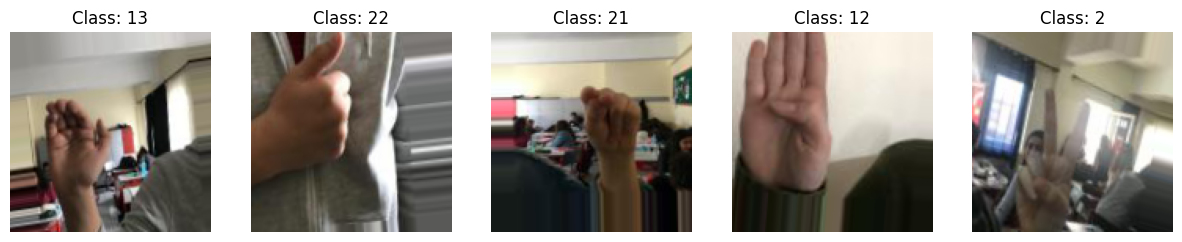

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(images, labels, num_samples=5, augmentation_type="Original"):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        
        # For grayscale images (single channel)
        if images[i].shape[-1] == 1:
            plt.imshow(images[i].squeeze(), cmap='gray')
        else:
            plt.imshow(images[i])
            
        plt.title(f"{augmentation_type}\nClass: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

# Generate a batch of augmented images
aug_images, aug_labels = next(train_generator)  # Correct syntax

# Plot samples
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    
    # For grayscale images (1 channel)
    if aug_images[i].shape[-1] == 1:
        plt.imshow(aug_images[i].squeeze(), cmap='gray')
    else:
        plt.imshow(aug_images[i])
    
    plt.title(f"Class: {np.argmax(aug_labels[i])}")
    plt.axis('off')
plt.show()

In [8]:
# Create a validation generator using ImageDataGenerator
val_datagen = ImageDataGenerator() # No augmentation 
val_generator = val_datagen.flow(
    x=X_val,
    y=y_val,
    batch_size=32,
    shuffle=False 
)

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [10]:
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)  
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

# Get input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

# Build model
model, base_model = build_resnet50_model(input_shape, num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history_top = model.fit(
    train_generator,
    epochs=10,  
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


# Evaluation
loss, accuracy = model.evaluate(X_val, y_val)
print(f"\nFinal Validation Accuracy: {accuracy*100:.2f}%")


I0000 00:00:1746299699.131246      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746299699.131865      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746299754.648820      93 service.cc:148] XLA service 0x77f6780039c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746299754.649551      93 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746299754.649571      93 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746299759.083715      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/570 ━━━━━━━━━━━━━━━━━━━━ 11:21:09 72s/step - accuracy: 0.0625 - loss: 3.7165

I0000 00:00:1746299777.382842      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


570/570 ━━━━━━━━━━━━━━━━━━━━ 151s 139ms/step - accuracy: 0.5070 - loss: 1.7015 - val_accuracy: 0.0353 - val_loss: 4.8633
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 77s 132ms/step - accuracy: 0.9090 - loss: 0.3050 - val_accuracy: 0.9623 - val_loss: 0.1425
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 80s 139ms/step - accuracy: 0.9405 - loss: 0.2117 - val_accuracy: 0.9684 - val_loss: 0.1167
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 85s 147ms/step - accuracy: 0.9526 - loss: 0.1644 - val_accuracy: 0.9759 - val_loss: 0.0952
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 86s 150ms/step - accuracy: 0.9599 - loss: 0.1384 - val_accuracy: 0.9268 - val_loss: 0.2478
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 88s 152ms/step - accuracy: 0.9670 - loss: 0.1225 - val_accuracy: 0.9715 - val_loss: 0.1058
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 87s 151ms/step - accuracy: 0.9707 - loss: 0.1044 - val_accuracy: 0.9695 - val_loss: 0.1355
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 83s 143ms/step - accuracy: 0.9709 - loss: 0.1041 - va

/tmp/ipykernel_31/3538927122.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


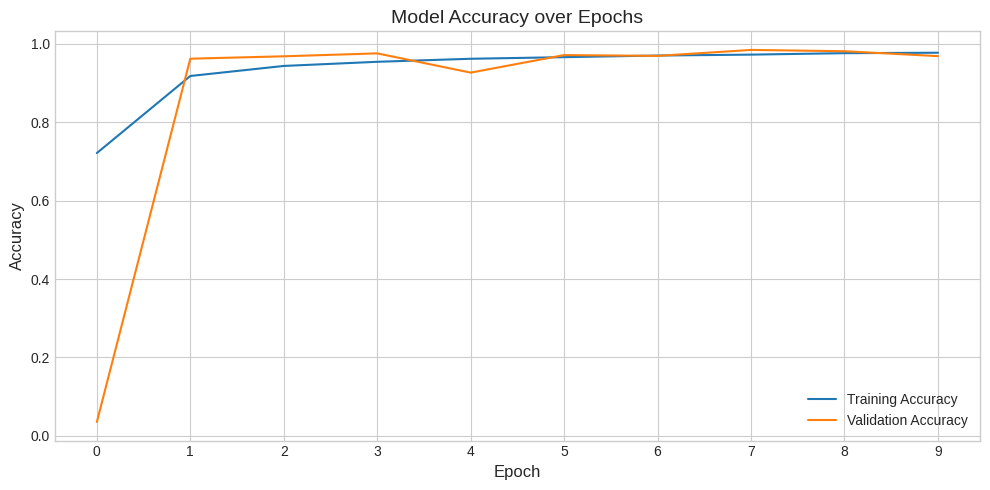

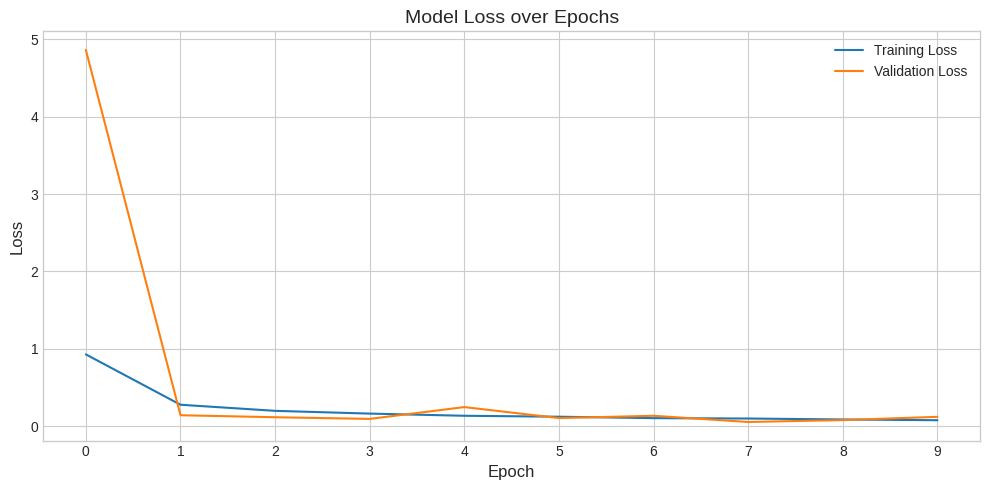

In [11]:
plt.style.use('seaborn-whitegrid')  

def plot_training_history(history):
    epochs = range(len(history.history['accuracy']))

    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(epochs)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history_top)


143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


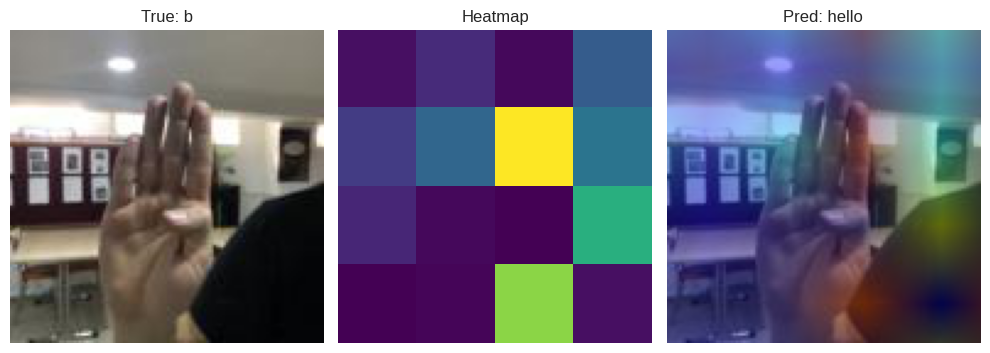

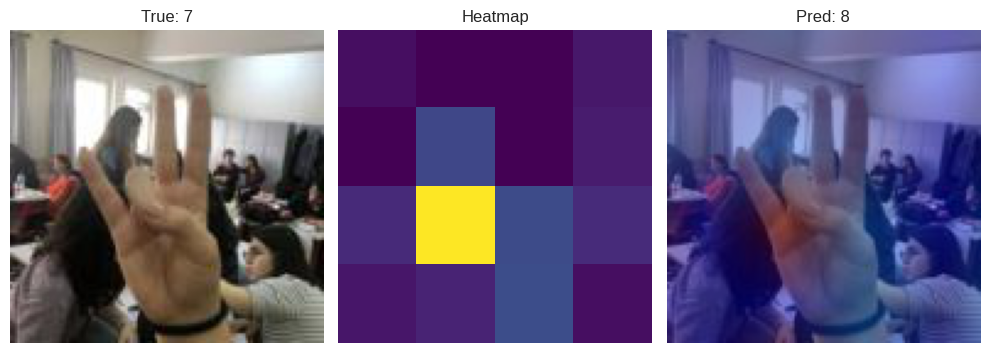

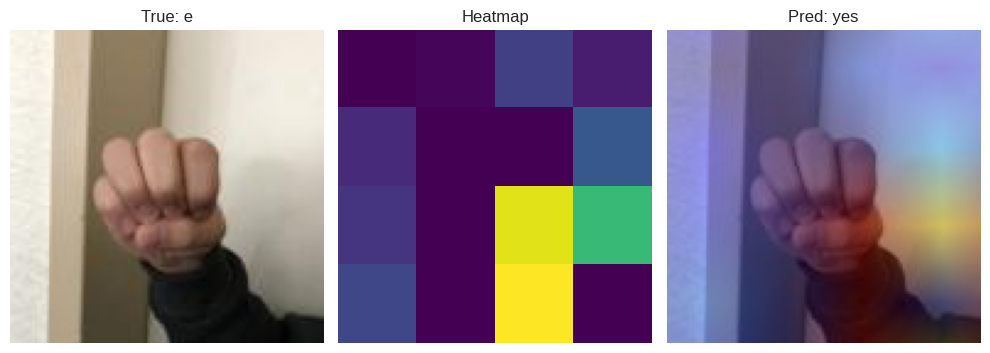

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from skimage.transform import resize


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap_uint8 = np.uint8(255 * heatmap)
    jet = plt.colormaps.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]
    jet_heatmap = resize(jet_heatmap, (img.shape[0], img.shape[1]), mode='reflect', anti_aliasing=True)


    if img.max() <= 1.0:
        img = img * 255
    img = img.astype(np.uint8)

    superimposed_img = (1 - alpha) * img / 255.0 + alpha * jet_heatmap
    superimposed_img = np.clip(superimposed_img * 255, 0, 255).astype(np.uint8)

    plt.imshow(superimposed_img)
    plt.axis('off')
    return superimposed_img

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

for i in misclassified_indices[:3]:
    img = X_val[i]
    img_array = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out')
    
    img_for_display = img
    if img_for_display.max() <= 1.0:
        img_for_display = (img_for_display * 255).astype(np.uint8)

    pred_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]

    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_for_display)
    plt.title(f"True: {true_label}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='viridis')
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    display_gradcam(img_for_display, heatmap)
    plt.title(f"Pred: {pred_label}")

    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

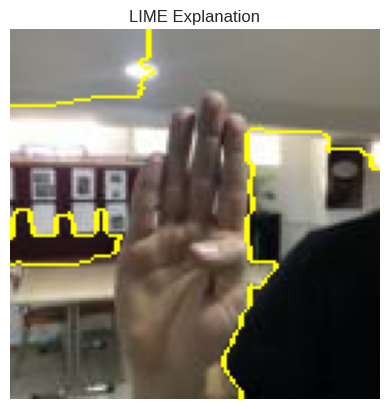

In [14]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

In [15]:
!pip install SHAP 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

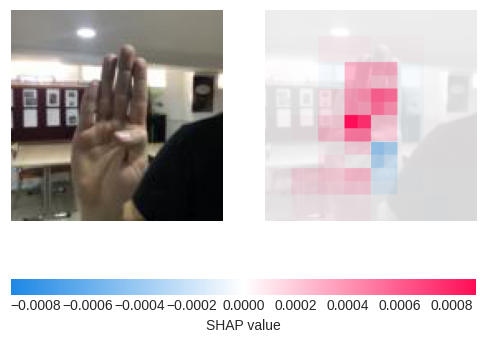

In [26]:
import shap
from shap.maskers import Image
import numpy as np


test_images = X_val[misclassified_indices[:1]]  

preds = model.predict(test_images)
pred_class = np.argmax(preds[0])  
masker = Image("blur(128,128)", test_images[0].shape)

explainer = shap.Explainer(
    lambda x: model.predict(x)[:, pred_class],  
    masker
)
shap_values = explainer(test_images)

shap.plots.image(shap_values)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def feature_ablation_heatmap(image, model, class_idx=None, patch_size=20):
    img = image.copy()
    h, w, c = img.shape
    n_patches_y = h // patch_size
    n_patches_x = w // patch_size
    heatmap = np.zeros((n_patches_y, n_patches_x))
    orig_pred = model.predict(img[None])[0]
    
    if class_idx is None:
        class_idx = np.argmax(orig_pred)
    orig_conf = orig_pred[class_idx]

    for i in range(n_patches_y):
        for j in range(n_patches_x):
            occluded = img.copy()
            y_start = i * patch_size
            x_start = j * patch_size

            
            occluded[y_start:y_start+patch_size, x_start:x_start+patch_size, :] = 0.5
            occl_pred = model.predict(occluded[None])[0][class_idx]
            delta = orig_conf - occl_pred
            heatmap[i, j] = delta

    
    heatmap_resized = np.kron(heatmap, np.ones((patch_size, patch_size)))
    heatmap_resized = heatmap_resized[:h, :w]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.title("Feature Ablation Map")
    plt.colorbar(label="Drop in confidence")
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

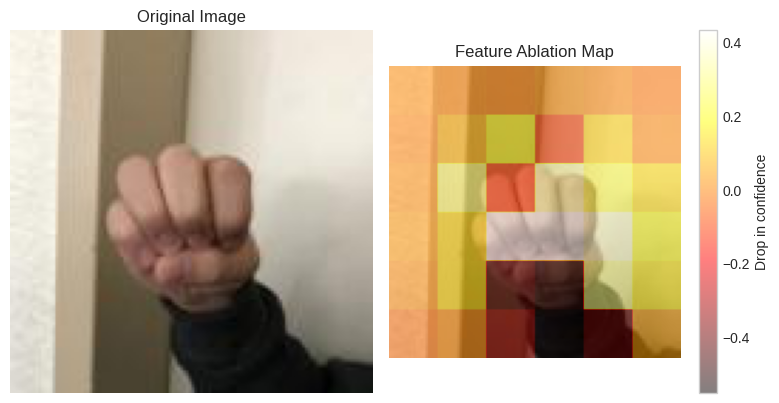

In [19]:
feature_ablation_heatmap(test_images[2], model)